In [1]:
import numpy as np
import scipy as sp
import networkx as nx

In [253]:
def rank(teams, teamcolors, games):
    G = nx.MultiDiGraph()
    G.add_nodes_from(teams)
    for game in games:
        G.add_edge(game[0], game[1])
    P = nx.drawing.nx_pydot.to_pydot(G)
    G_orig = G.copy()
    for game in games:
        G.add_edge(game[0], game[0])

    G = G.reverse()

    pr = nx.pagerank_numpy(G, alpha=0.85)

    sorts = list(sorted(pr.keys(), key=lambda k: pr[k], reverse=True))

    print('  PR TEAM  PR-SCORE   W/L    %')
    for i in range(len(sorts)):
        team = sorts[i]
        wins = len(G_orig.out_edges(team))
        losses = len(G_orig.in_edges(team))
        print('{:3d}) {:5s} {:.5f}    {:d}/{:d}  {:3.0f}'.format(i + 1, team, pr[team], wins, losses, 100 * wins / (wins + losses)))


    for team in teams:
        color = teamcolors[team]
        node = P.get_node(team)[0]
        node.set_color(color)
        node.set_fontcolor(color)
        node.set_label('#{} {}\n{:.5f}'.format(sorts.index(team) + 1, team, pr[team]))
    for edge in P.get_edges():
        color = teamcolors[edge.get_source()]
        edge.set_color(color)

    P.set_layout('circo')
    P.write('graph.png', prog='neato', format='png')
    from IPython.display import Image
    return Image('graph.png')

  PR TEAM  PR-SCORE   W/L    %
  1) FOX   0.45317    4/0  100
  2) C9    0.14021    3/1   75
  3) 100   0.13050    3/1   75
  4) TL    0.09864    3/1   75
  5) FLY   0.04169    2/2   50
  6) CG    0.04017    2/2   50
  7) OPT   0.03030    1/3   25
  8) TSM   0.02722    1/3   25
  9) CLG   0.02310    1/3   25
 10) GGS   0.01500    0/4    0


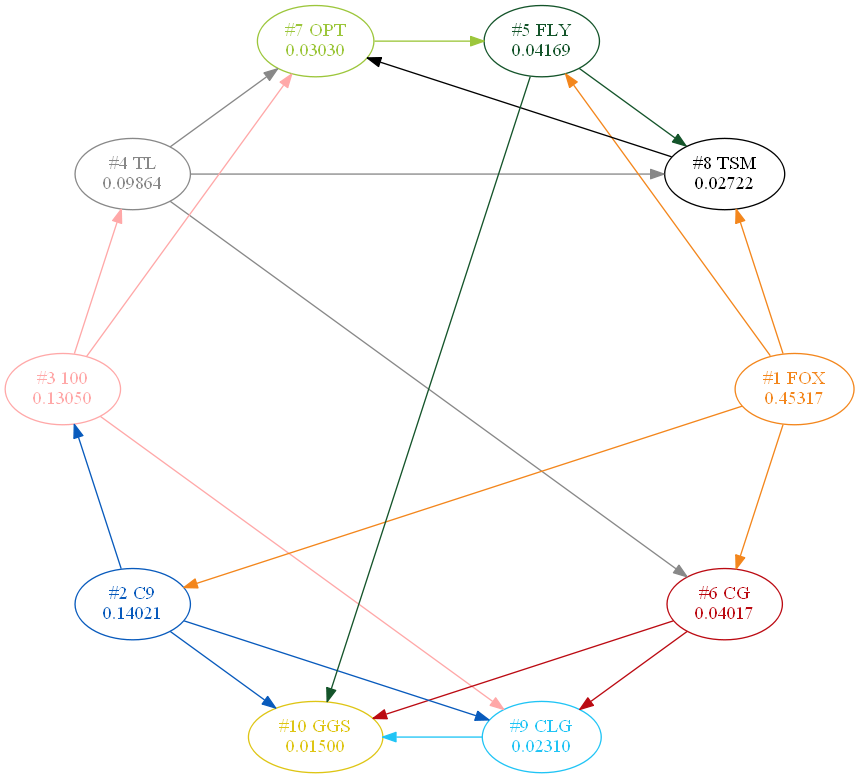

In [255]:
nalcs = {
    'teams': [
        'TL',
        '100',
        'CG',
        'FOX',
        'C9',
        'TSM',
        'OPT',
        'GGS',
        'FLY',
        'CLG',
    ],
    'teamcolors': {
        'TL': '#888888',
        '100': '#ffa8a8',
        'CG': '#bb0a12',
        'FOX': '#f3861c',
        'C9': '#085abc',
        'TSM': '#000000',
        'OPT': '#9cc63b',
        'GGS': '#dec514',
        'FLY': '#14542a',
        'CLG': '#20c4f5',
    },
    'games': [
        # (winner, loser)
        # w1d1
        ('TL', 'TSM'),
        ('100', 'OPT'),
        ('CG', 'GGS'),
        ('FOX', 'FLY'),
        ('C9', 'CLG'),
        # w1d2
        ('TL', 'OPT'),
        ('FLY', 'TSM'),
        ('100', 'CLG'),
        ('C9', 'GGS'),
        ('FOX', 'CG'),
        # w2d1
        ('CG', 'CLG'),
        ('TSM', 'OPT'),
        ('FOX', 'C9'),
        ('100', 'TL'),
        ('FLY', 'GGS'),
        # w2d2
        ('FOX', 'TSM'),
        ('C9', '100'),
        ('OPT', 'FLY'),
        ('CLG', 'GGS'),
        ('TL', 'CG'),
    ]
}
rank(**nalcs)

  PR TEAM  PR-SCORE   W/L    %
  1) MSF   0.21741    3/1   75
  2) VIT   0.18005    3/1   75
  3) ROC   0.13167    3/1   75
  4) GIA   0.11915    3/1   75
  5) S04   0.08029    2/2   50
  6) G2    0.07771    1/3   25
  7) FNC   0.07746    2/2   50
  8) SPY   0.06130    2/2   50
  9) H2K   0.03995    1/3   25
 10) UOL   0.01500    0/4    0


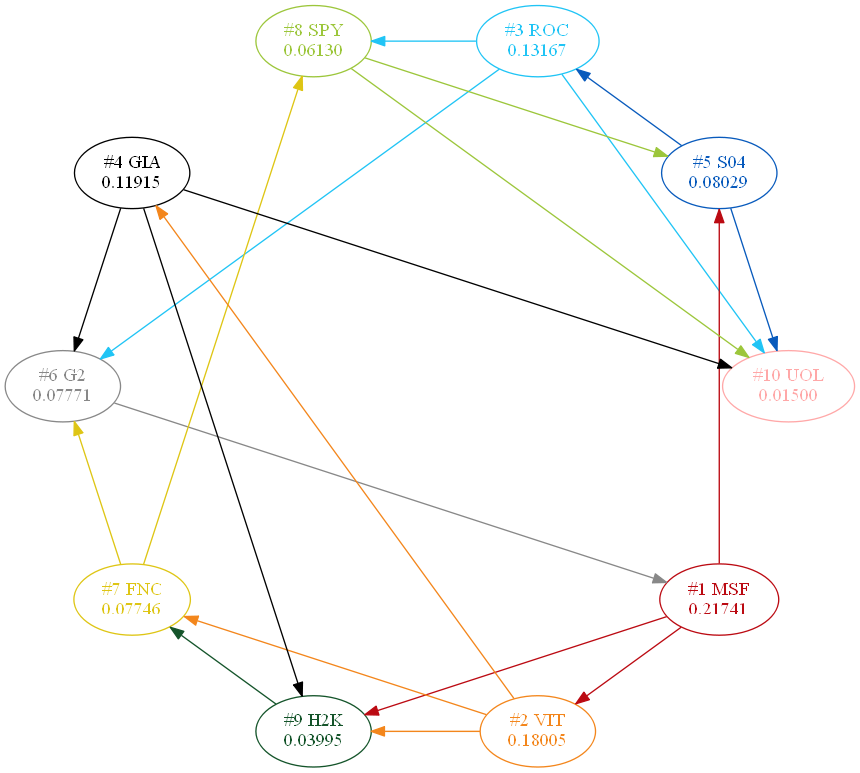

In [258]:
eulcs = {
    'teams': [
        'G2',
        'H2K',
        'UOL',
        'ROC',
        'FNC',
        'MSF',
        'VIT',
        'GIA',
        'S04',
        'SPY',
    ],
    'teamcolors': {
        'G2': '#888888',
        'UOL': '#ffa8a8',
        'VIT': '#f3861c',
        'MSF': '#bb0a12',
        'S04': '#085abc',
        'ROC': '#20c4f5',
        'GIA': '#000000',
        'SPY': '#9cc63b',
        'FNC': '#dec514',
        'H2K': '#14542a',
    },
    'games': [
        # (winner, loser)
        # w1d1
        ('G2', 'MSF'),
        ('VIT', 'H2K'),
        ('GIA', 'UOL'),
        ('S04', 'ROC'),
        ('FNC', 'SPY'),
        # w1d2
        ('VIT', 'GIA'),
        ('SPY', 'UOL'),
        ('H2K', 'FNC'),
        ('ROC', 'G2'),
        ('MSF', 'S04'),
        # w2d1
        ('GIA', 'G2'),
        ('ROC', 'SPY'),
        ('MSF', 'H2K'),
        ('VIT', 'FNC'),
        ('S04', 'UOL'),
        # w2d2
        ('GIA', 'H2K'),
        ('ROC', 'UOL'),
        ('MSF', 'VIT'),
        ('SPY', 'S04'),
        ('FNC', 'G2'),
    ]
}
rank(**eulcs)

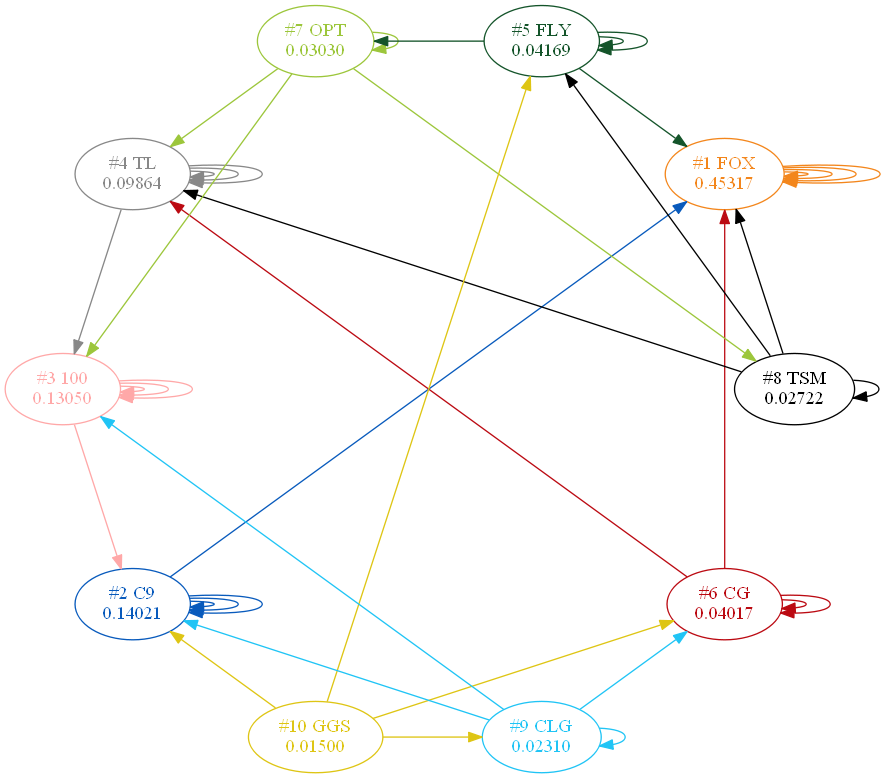

In [247]:
P = nx.drawing.nx_pydot.to_pydot(G)

for team in teams:
    color = teamcolors[team]
    node = P.get_node(team)[0]
    node.set_color(color)
    node.set_fontcolor(color)
    node.set_label('#{} {}\n{:.5f}'.format(sorts.index(team) + 1, team, pr[team]))
for edge in P.get_edges():
    color = teamcolors[edge.get_source()]
    edge.set_color(color)

P.set_layout('circo')
P.write('graph.png', prog='neato', format='png')
from IPython.display import Image
Image('graph.png')